In [66]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from metrics import print_metrics_binary
import matplotlib.pyplot as plt
#from tqdm import TqdmSynchronisationWarning
np.set_printoptions(threshold=50, edgeitems=20)

In [2]:
#print(torch.cuda.current_device())
#torch.cuda.set_device(1)

In [3]:
#warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)

In [4]:
train = pd.read_csv('./datasets/ihm/train_data.csv')
test = pd.read_csv('./datasets/ihm/test_data.csv')
val = pd.read_csv('./datasets/ihm/val_data.csv')
train_data = train.drop('Unnamed: 0', axis=1)
test_data = test.drop('Unnamed: 0', axis=1)
val_data = val.drop('Unnamed: 0', axis=1)

In [5]:
def balance_dataset(df):
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died*2 > counter:
            new_patient = patient.copy()
            new_patient["Episode"] = ("e" + str(counter))
            split_set.append(patient)
            counter = counter +1
    print(num_died+counter, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    complete_data = pd.concat(split_set)
    return complete_data


In [6]:
train_data = train_data.reset_index().drop('index', axis=1)
val_data = val_data.reset_index().drop('index', axis=1)
test_data = test_data.reset_index().drop('index', axis=1)

In [7]:
train_size = len(train_data)
train_data = train_data.append(val_data)


print(train_size)
print(len(train_data))
val_idx = list(range(train_size, len(train_data)))

14497
17680


In [8]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response']

all_cat_vars = []
counter = 0
for cat in cat_vars:
    for i in range(0,100):
        all_cat_vars.append(cat+str(i))

all_cat_vars.append('Length')
for v in all_cat_vars: train_data[v] = train_data[v].astype('category').cat.as_ordered()
for v in all_cat_vars: test_data[v] = test_data[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train_data[c].cat.categories)+1) for c in all_cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate0', 3), ('Capillary refill rate1', 3), ('Capillary refill rate2', 3), ('Capillary refill rate3', 3), ('Capillary refill rate4', 3), ('Capillary refill rate5', 3), ('Capillary refill rate6', 3), ('Capillary refill rate7', 3), ('Capillary refill rate8', 3), ('Capillary refill rate9', 3), ('Capillary refill rate10', 3), ('Capillary refill rate11', 3), ('Capillary refill rate12', 3), ('Capillary refill rate13', 3), ('Capillary refill rate14', 3), ('Capillary refill rate15', 3), ('Capillary refill rate16', 3), ('Capillary refill rate17', 3), ('Capillary refill rate18', 3), ('Capillary refill rate19', 3), ('Capillary refill rate20', 3), ('Capillary refill rate21', 3), ('Capillary refill rate22', 3), ('Capillary refill rate23', 3), ('Capillary refill rate24', 3), ('Capillary refill rate25', 3), ('Capillary refill rate26', 3), ('Capillary refill rate27', 3), ('Capillary refill rate28', 3), ('Capillary refill rate29', 3), ('Capillary refill rate30', 3), ('Capillary refil

In [12]:
test_data.head()

,Hours0,Capillary refill rate0,Diastolic blood pressure0,Fraction inspired oxygen0,Glascow coma scale eye opening0,Glascow coma scale motor response0,Glascow coma scale total0,Glascow coma scale verbal response0,Glucose0,Heart Rate0,...,Height99,Mean blood pressure99,Oxygen saturation99,Respiratory rate99,Systolic blood pressure99,Temperature99,Weight99,pH99,Length,Mortality
0,0.433333,0.0,49.0,0.21,Spontaneously,Obeys Commands,15.0,Oriented,128.0,81.0,...,170.0,64.333298,98.0,16.0,99.0,36.333334,81.000000,7.47,100,1
1,0.078333,0.0,38.0,0.21,Spontaneously,Obeys Commands,15.0,Oriented,128.0,65.0,...,170.0,82.000000,98.0,10.0,169.0,37.055599,64.900002,5.00,100,0
2,0.700000,0.0,43.0,0.21,Spontaneously,Obeys Commands,15.0,Oriented,128.0,70.0,...,170.0,54.666698,97.0,25.0,100.0,36.333334,81.000000,7.40,100,0
3,0.316944,0.0,64.0,0.21,Spontaneously,Obeys Commands,15.0,Oriented,128.0,67.0,...,170.0,67.000000,94.0,17.0,109.0,37.700001,90.199997,7.37,100,0
4,2.089167,0.0,35.0,0.21,To Speech,Localizes Pain,10.0,Incomprehensible sounds,128.0,96.0,...,170.0,69.000000,99.0,13.0,105.0,35.222223,83.000000,7.40,100,0


In [9]:
print(len(train_data[train_data['Mortality'] == 1]))
print(len(train_data[train_data['Mortality'] == 0]))

2402
15278


In [21]:
print(len(train_data.columns))
print(len(test_data.columns))

1802
1802


In [196]:
df, y, nas, mapper = proc_df(train_data, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test_data, 'Mortality', do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=all_cat_vars, bs=32,
                                       test_df=df_test)

In [215]:
m = md.get_learner(emb_szs, len(df.columns)-len(all_cat_vars),
                   0.04, 1, [500,250], [0.001,0.01], y_range=[0,1], crit = torch.nn.functional.binary_cross_entropy)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 63%|██████▎   | 288/454 [00:25<00:14, 11.42it/s, loss=1.35] 

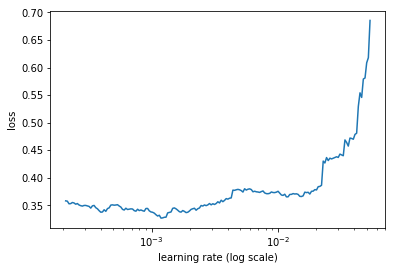

 63%|██████▎   | 288/454 [00:40<00:23,  7.20it/s, loss=1.35]

In [216]:
m.lr_find()
m.sched.plot(100)


In [217]:
lr = 0.0001


In [218]:
lrs = [lr/18, lr/9, lr/6]

In [219]:
m.fit(lrs, 2, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

 10%|█         | 47/454 [00:04<00:38, 10.61it/s, loss=0.728]

Exception in thread Thread-206:
Traceback (most recent call last):
  File "/home/andreas/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andreas/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/andreas/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                               
    0      0.330553   0.336411  
    1      0.319664   0.330256                               
    2      0.302278   0.313701                               
    3      0.276005   0.307034                               
    4      0.289316   0.304794                               
    5      0.269852   0.304529                               



[array([0.30453])]

In [220]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2752   65]
 [ 284   84]]
accuracy = 0.89042383
precision class 0 = 0.9064559
precision class 1 = 0.5637584
recall class 0 = 0.9769258
recall calss 1 = 0.22826087
AUC of ROC = 0.6025933385809756
AUC of PRC = 0.44059361685461146
min(+P, Se) = 0.22826086956521738


In [221]:
m.fit(lrs, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.34398    0.300917  
    1      0.271364   0.300342                               



[array([0.30034])]

In [222]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2724   93]
 [ 253  115]]
accuracy = 0.89136577
precision class 0 = 0.9150151
precision class 1 = 0.55288464
recall class 0 = 0.9669862
recall calss 1 = 0.3125
AUC of ROC = 0.639743077742279
AUC of PRC = 0.47240973312401885
min(+P, Se) = 0.3125


In [223]:
m.fit(0.001, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.304522   0.297753  
    1      0.275755   0.297202                               



[array([0.2972])]

In [224]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2739   78]
 [ 254  114]]
accuracy = 0.8957614
precision class 0 = 0.9151353
precision class 1 = 0.59375
recall class 0 = 0.97231096
recall calss 1 = 0.3097826
AUC of ROC = 0.6410467889058665
AUC of PRC = 0.4916407156508088
min(+P, Se) = 0.30978260869565216


In [225]:
m.fit(lrs, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.254274   0.295335  
    1      0.247248   0.295072                               
    2      0.27791    0.295071                               
    3      0.261464   0.294726                               



[array([0.29473])]

In [226]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2725   92]
 [ 246  122]]
accuracy = 0.89387757
precision class 0 = 0.9171996
precision class 1 = 0.57009345
recall class 0 = 0.9673411
recall calss 1 = 0.33152175
AUC of ROC = 0.6494314410952138
AUC of PRC = 0.48942612286999
min(+P, Se) = 0.33152173913043476


In [227]:
m.fit(0.001, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.260121   0.30052   
    1      0.253116   0.305957                               



[array([0.30596])]

In [228]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2703  114]
 [ 231  137]]
accuracy = 0.89167976
precision class 0 = 0.92126787
precision class 1 = 0.5458167
recall class 0 = 0.9595314
recall calss 1 = 0.3722826
AUC of ROC = 0.665907012548039
AUC of PRC = 0.4953134071454269
min(+P, Se) = 0.37228260869565216


In [229]:
m.fit(0.001, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.246901   0.303208  
    1      0.216855   0.305055                               



[array([0.30506])]

In [ ]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)

confusion matrix:
[[2711  106]
 [ 239  129]]
accuracy = 0.89167976
precision class 0 = 0.91898304
precision class 1 = 0.5489362
recall class 0 = 0.9623713
recall calss 1 = 0.35054347
AUC of ROC = 0.6564573976323873
AUC of PRC = 0.4872594474707267
min(+P, Se) = 0.35054347826086957


In [ ]:
m.fit(0.0001, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.172799   0.317415  
 77%|███████▋  | 350/454 [00:30<00:09, 11.37it/s, loss=0.179]

In [ ]:
y_predicted = m.predict(is_test=True)
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
metrics = print_metrics_binary(y_test, preds)